# Project: Image Classification and Regression

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.patches as patches
from keras.layers import Conv1D, MaxPooling1D

In [4]:
#Keras moduls
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential 
from keras.layers import Dense, Activation

Using TensorFlow backend.


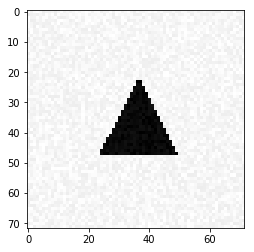

In [3]:
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


In [5]:
[X_train, Y_train] = generate_dataset_classification(300, 20) 
# Convert labels to categorical one-hot encoding
Y_train = np_utils.to_categorical(Y_train, num_classes=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [13]:
#Stochastic Gradient Descent 
# For a three-class classification problem
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=5184))
model.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,metrics=['accuracy']) 

#training the model  
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 6.1776 - acc: 0.3533
Epoch 2/10
300/300 [==============================] - 0s 413us/step - loss: 2.5328 - acc: 0.5133
Epoch 3/10
300/300 [==============================] - 0s 326us/step - loss: 0.9427 - acc: 0.5567
Epoch 4/10
300/300 [==============================] - 0s 350us/step - loss: 0.8227 - acc: 0.6133
Epoch 5/10
300/300 [==============================] - 0s 350us/step - loss: 0.6875 - acc: 0.6667
Epoch 6/10
300/300 [==============================] - 0s 346us/step - loss: 1.1310 - acc: 0.3233
Epoch 7/10
300/300 [==============================] - 0s 430us/step - loss: 1.1317 - acc: 0.3467
Epoch 8/10
300/300 [==============================] - 0s 410us/step - loss: 1.1201 - acc: 0.3467
Epoch 9/10
300/300 [==============================] - 0s 363us/step - loss: 1.1096 - acc: 0.3467
Epoch 10/10
300/300 [==============================] - 0s 660us/step - loss: 1.1040 - acc: 0.3467


In [14]:
#testing
X_test = generate_a_disk() #classe 1
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test,batch_size=32, verbose=0)

array([[0.36641935, 0.33615622, 0.2974245 ]], dtype=float32)

In [15]:
# For a three-class classification problem
model_A = Sequential()
model_A.add(Dense(20, activation='relu', input_dim=5184))
model_A.add(Dense(3, activation='softmax'))
model_A.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy']) 
#training the model
model_A.fit(X_train, Y_train, epochs=10, batch_size=32)


Epoch 1/10
300/300 [==============================] - 1s 4ms/step - loss: 1.5550 - acc: 0.3433
Epoch 2/10
300/300 [==============================] - 0s 516us/step - loss: 0.9855 - acc: 0.5500
Epoch 3/10
300/300 [==============================] - 0s 506us/step - loss: 0.9157 - acc: 0.5933
Epoch 4/10
300/300 [==============================] - 0s 973us/step - loss: 0.8516 - acc: 0.6100
Epoch 5/10
300/300 [==============================] - 0s 520us/step - loss: 0.8081 - acc: 0.5900
Epoch 6/10
300/300 [==============================] - 0s 586us/step - loss: 0.7833 - acc: 0.6233
Epoch 7/10
300/300 [==============================] - 0s 496us/step - loss: 0.7617 - acc: 0.6367
Epoch 8/10
300/300 [==============================] - 0s 463us/step - loss: 0.7487 - acc: 0.6467
Epoch 9/10
300/300 [==============================] - 0s 586us/step - loss: 0.7360 - acc: 0.6567
Epoch 10/10
300/300 [==============================] - 0s 456us/step - loss: 0.7291 - acc: 0.6667


In [16]:
#testing
X_test = generate_a_disk() #classe 1
X_test = X_test.reshape(1, X_test.shape[0])
model_A.predict(X_test,batch_size=32, verbose=0)

array([[0.343143  , 0.34773532, 0.30912167]], dtype=float32)

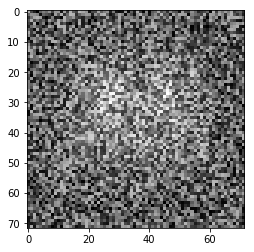

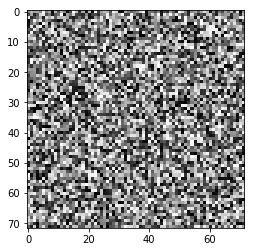

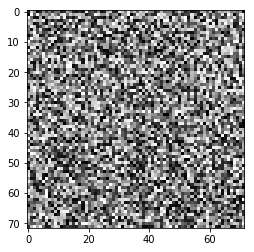

In [17]:
# SGD optimizer
W = model.layers[0].get_weights()
plt.imshow(W[0][:,0].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,1].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,2].reshape(72,72), cmap='gray')
plt.show()

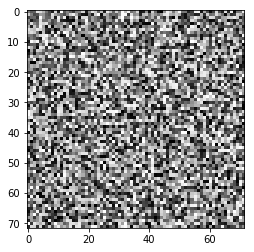

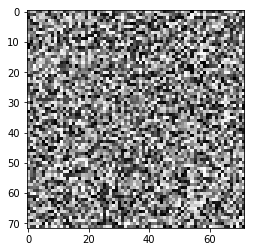

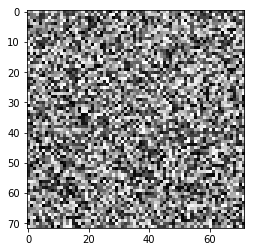

In [18]:
# Adam optimizer
W = model_A.layers[0].get_weights()
plt.imshow(W[0][:,0].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,1].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,2].reshape(72,72), cmap='gray')
plt.show()

In [19]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train, num_classes=3)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 1ms/step


[1.7859246921539307, 0.40333333253860476]

In [20]:
#Stochastic Gradient Descent 
# For a three-class classification problem
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=5184))
model.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,metrics=['accuracy']) 

#training the model  
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 2ms/step - loss: 5.4481 - acc: 0.2867
Epoch 2/10
300/300 [==============================] - 0s 413us/step - loss: 1.1049 - acc: 0.3600
Epoch 3/10
300/300 [==============================] - 0s 373us/step - loss: 1.0978 - acc: 0.3600
Epoch 4/10
300/300 [==============================] - 0s 476us/step - loss: 1.0975 - acc: 0.3600
Epoch 5/10
300/300 [==============================] - 0s 443us/step - loss: 1.0975 - acc: 0.3600
Epoch 6/10
300/300 [==============================] - 0s 456us/step - loss: 1.0974 - acc: 0.3600
Epoch 7/10
300/300 [==============================] - 0s 366us/step - loss: 1.0974 - acc: 0.3600
Epoch 8/10
300/300 [==============================] - 0s 613us/step - loss: 1.0974 - acc: 0.3600
Epoch 9/10
300/300 [==============================] - 0s 620us/step - loss: 1.0972 - acc: 0.3600
Epoch 10/10
300/300 [==============================] - 0s 503us/step - loss: 1.0972 - acc: 0.3600


In [21]:
[X_test, Y_test] = generate_test_set_classification()

model.evaluate(X_test, Y_test) #SGD optimizer

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 770us/step


[1.100696431795756, 0.3299999996026357]

In [22]:
# For a three-class classification problem
model_A = Sequential()
model_A.add(Dense(20, activation='relu', input_dim=5184))
model_A.add(Dense(3, activation='softmax'))
model_A.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy']) 
#training the model
model_A.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 1.9460 - acc: 0.3000
Epoch 2/10
300/300 [==============================] - 0s 393us/step - loss: 1.3469 - acc: 0.3533
Epoch 3/10
300/300 [==============================] - 0s 400us/step - loss: 1.1513 - acc: 0.3733
Epoch 4/10
300/300 [==============================] - 0s 460us/step - loss: 0.9840 - acc: 0.4833
Epoch 5/10
300/300 [==============================] - 0s 453us/step - loss: 0.9303 - acc: 0.5467
Epoch 6/10
300/300 [==============================] - 0s 400us/step - loss: 0.9233 - acc: 0.5067
Epoch 7/10
300/300 [==============================] - 0s 443us/step - loss: 0.9294 - acc: 0.5233
Epoch 8/10
300/300 [==============================] - 0s 626us/step - loss: 0.9994 - acc: 0.5633
Epoch 9/10
300/300 [==============================] - 0s 446us/step - loss: 0.9608 - acc: 0.5433
Epoch 10/10
300/300 [==============================] - 0s 706us/step - loss: 0.9537 - acc: 0.5667


In [23]:
model_A.evaluate(X_test, Y_test) #SGD optimizer

300/300 [==============================] - 0s 826us/step


[0.9136123784383138, 0.5133333337306977]

In [25]:
#creating a new model
X_train=X_train.reshape([-1,300, 5184])
Y_train=Y_train.reshape([-1,300, 3])
##Convolution1D
model2 = Sequential() 
model2.add(Conv1D(16, 5, activation='relu',input_shape=(300,5184))) 
print(model2.output_shape)

model2.add(MaxPooling1D(5))
print(model2.output_shape)

#model.add(Dense(3, activation='relu')) 

model2.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
model2.fit(X_train, Y_train, epochs=20, batch_size=32)

(None, 296, 16)
(None, 59, 16)


ValueError: Error when checking target: expected max_pooling1d_1 to have shape (59, 16) but got array with shape (300, 3)

In [26]:
model2.evaluate(X_test, Y_test)

NameError: name 'model2' is not defined

In [28]:
#normalize vertices
def normer(Y):
    for i in range(len(Y)):
        a = math.sqrt(Y[i,0]**2 + Y[i,1]**2)
        b = math.sqrt(Y[i,2]**2 + Y[i,3]**2)
        c = math.sqrt(Y[i,4]**2 + Y[i,5]**2)
        Y[i,:]=[Y[i,0]/a,Y[i,1]/a,Y[i,2]/b,Y[i,3]/b,Y[i,4]/c,Y[i,5]/c]
    return Y


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


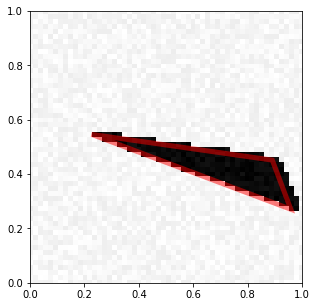

In [29]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
visualize_prediction(X_train[0], Y_train[0])

In [30]:
Y_train = normer(Y_train)

model_r = Sequential()
model_r.add(Dense(20, activation='relu', input_dim=5184))
model_r.add(Dense(6, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_r.compile(loss='mean_squared_error', optimizer=sgd,metrics=['accuracy']) 
    #training the model  


model_r.fit(X_train, Y_train, epochs=10, batch_size=32)


Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 0.3288 - acc: 0.1900
Epoch 2/10
300/300 [==============================] - 0s 436us/step - loss: 0.3140 - acc: 0.1767
Epoch 3/10
300/300 [==============================] - 0s 396us/step - loss: 0.3121 - acc: 0.2067
Epoch 4/10
300/300 [==============================] - 0s 546us/step - loss: 0.3114 - acc: 0.2233
Epoch 5/10
300/300 [==============================] - 0s 300us/step - loss: 0.3109 - acc: 0.1900
Epoch 6/10
300/300 [==============================] - 0s 500us/step - loss: 0.3107 - acc: 0.1933
Epoch 7/10
300/300 [==============================] - 0s 456us/step - loss: 0.3102 - acc: 0.1867
Epoch 8/10
300/300 [==============================] - 0s 503us/step - loss: 0.3096 - acc: 0.1933
Epoch 9/10
300/300 [==============================] - 0s 456us/step - loss: 0.3095 - acc: 0.2000
Epoch 10/10
300/300 [==============================] - 0s 646us/step - loss: 0.3090 - acc: 0.1967


In [31]:
[X_test, Y_test] = generate_test_set_regression()
Y_test = normer(Y_test)
Y_pred = model.predict(X_test,batch_size=32, verbose=0)
Y_pred = normer(Y_pred)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


ValueError: Error when checking input: expected conv1d_1_input to have 3 dimensions, but got array with shape (300, 5184)